# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
BASE_PATH = os.getcwd().replace("\\", "/")

In [19]:
artist_data = pd.read_csv(BASE_PATH + "/data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [47]:
user_artist_plays = pd.read_csv(BASE_PATH + "/data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [29]:
# ¿Cuáles son los artistas que fueron más escuchados?

most_listened_artists = user_artist_plays.groupby(["artistID"]).agg({"weight": "sum"})
most_listened_artists_by_name = pd.merge(
    left=most_listened_artists, right=artist_data,
    left_on="artistID",         right_on="id")
top_10_most_listened_artists_by_name = most_listened_artists_by_name[["name", "weight"]].sort_values("weight", ascending=False).head(10)
display(top_10_most_listened_artists_by_name)

,name,weight
283,Britney Spears,2393140
66,Depeche Mode,1301308
83,Lady Gaga,1291387
286,Christina Aguilera,1058405
492,Paramore,963449
61,Madonna,921198
282,Rihanna,905423
695,Shakira,688529
221,The Beatles,662116
294,Katy Perry,532545


,count,mean,std,min,25%,50%,75%,max
weight,1892.0,36566.582981,48744.552394,3.0,9742.25,21573.0,42963.75,480039.0


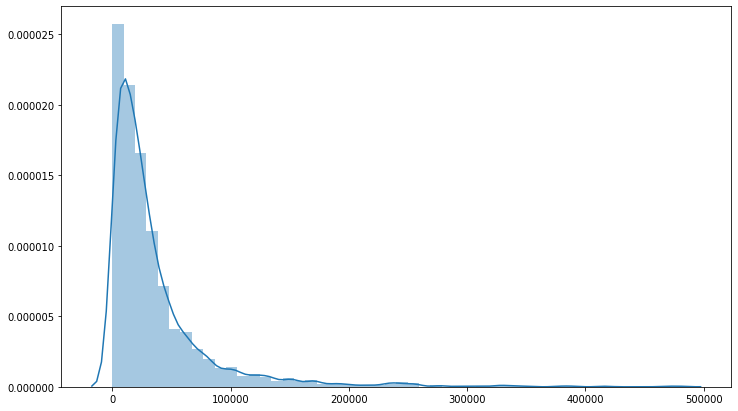

In [49]:
# ¿Cómo es la distribución de cantidad de listens por user?

listens_per_user = user_artist_plays.groupby(["userID"]).agg({"weight": "sum"})
display(listens_per_user.describe().T)
plt.figure(figsize=(12, 7))
sns.distplot(listens_per_user)

In [78]:
# ¿Es posible ver el género más escuchado?
tags = pd.read_csv(BASE_PATH + '/data/lastfm/tags.dat', sep = '\t', encoding = 'latin-1')
user_taggedartists = pd.read_csv(BASE_PATH + '/data/lastfm/user_taggedartists.dat', sep = '\t')

# display(tags.head())
# display(user_taggedartists.head())

genre_listens_count = user_taggedartists.groupby(["tagID"]).agg({"tagID": "count"}).rename(columns = {'tagID':'weight'})
artist_tagged_by_genre = pd.merge(
    left=tags, right=genre_listens_count,
    left_on="tagID",         right_on="tagID")
# display(artist_tagged_by_genre.head())

top_10_most_listened_genre = artist_tagged_by_genre.sort_values("weight", ascending=False).head(10)
# display(top_10_most_listened_genre)

print("The most listened genre is: \n", top_10_most_listened_genre.tagValue.head(1))

The most listened genre is: 
 71    rock
Name: tagValue, dtype: object


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [ ]:
# Completar...

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [ ]:
# Completar...

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [ ]:
# Completar...